In [1]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Sequence, Optional, Tuple, Literal

In [2]:
#functions
def plot_confusion_heatmap(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    class_names: Sequence[str],
    title: str = "Confusion Matrix",
    normalize: Optional[Literal["true", "pred", "all"]] = None,
    figsize: Tuple[int, int] = (12, 8),
    cmap: str = "Blues",
    annot: bool = True,
    fmt: Optional[str] = None,
) -> None:
    """
    Plots a confusion matrix heatmap for multi-class classification.

    Args:
    - y_true (np.ndarray): Ground-truth labels (encoded as integers).
    - y_pred (np.ndarray): Predicted labels (encoded as integers).
    - class_names (Sequence[str]): Class names in encoder order (e.g., label_encoder.classes_).
    - title (str): Title of the plot.
    - normalize (Optional[Literal['true','pred','all']]): Normalization mode per sklearn.confusion_matrix.
    - figsize (Tuple[int, int]): Figure size in inches (width, height).
    - cmap (str): Matplotlib colormap name.
    - annot (bool): Whether to annotate cell values.
    - fmt (Optional[str]): Annotation format; defaults to 'd' if unnormalized else '.2f'.

    Returns:
    - None
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    if fmt is None:
        fmt = ".2f" if normalize else "d"

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=annot,
        fmt=fmt,
        xticklabels=class_names,
        yticklabels=class_names,
        cmap=cmap,
        cbar_kws={"label": "Proportion" if normalize else "Count"},
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [3]:
#load models and components
log_reg_model = joblib.load("../models/logreg.joblib")
svm_model = joblib.load("../models/svm.joblib")
rf_model = joblib.load("../models/rfc.joblib")
xgb_model = joblib.load("../models/xgb.joblib")
tfidf_vectorizer = joblib.load("../models/tfidf.joblib")
label_encoder = joblib.load("../models/label_encoder.joblib")
scaler = joblib.load("../models/scaler.joblib")

#load validation data and embeddings
val_data = pd.read_csv("../data/processed/val_tickets.csv")
val_embeddings = np.load("../data/processed/X_val_sbert.npy")

#### Logisitic Regression

Logistic Regression Macro F1: 0.6139
Logistic Regression Weighted F1: 0.6241


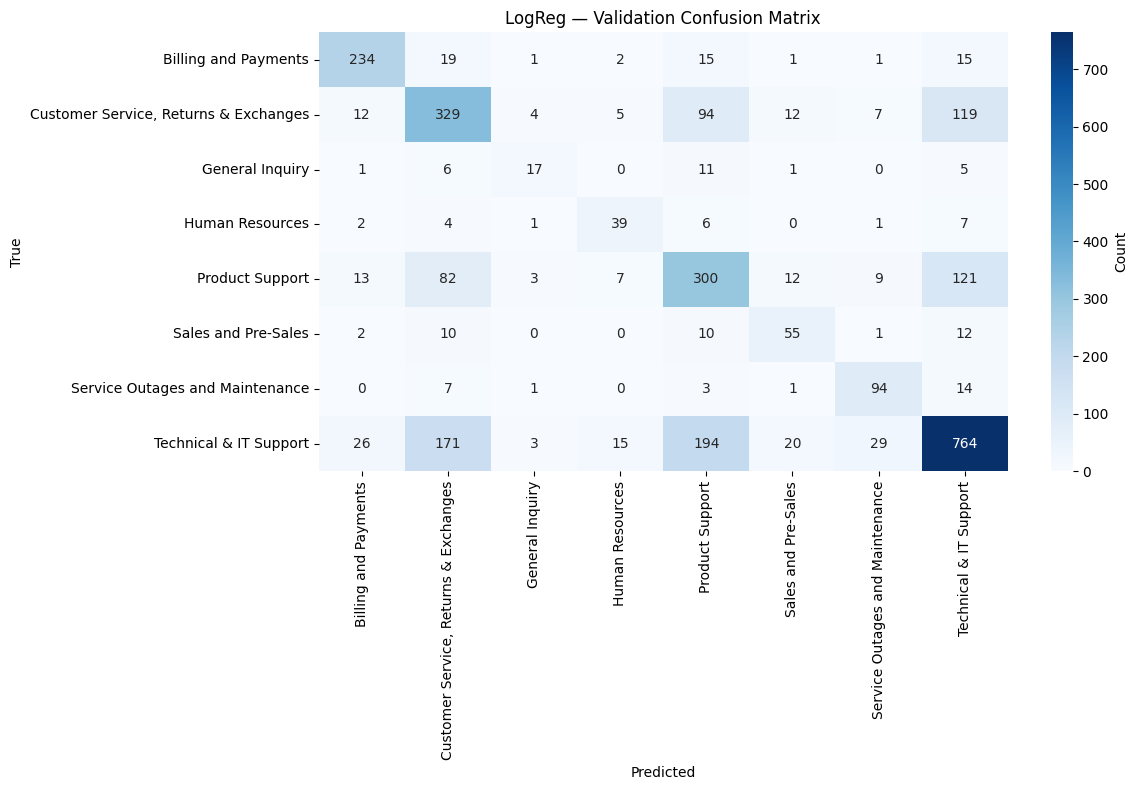

In [4]:
# declare log_reg_X and log_reg_y for logistic regression
log_reg_raw_y = val_data["queue_grouped"].astype(str)
log_reg_raw_X = val_data["redacted_text_clean"]

#encode labels
log_reg_enc_y = label_encoder.transform(log_reg_raw_y)

#vectorize text
log_reg_vec_x = tfidf_vectorizer.transform(log_reg_raw_X)

#make predictions
log_reg_preds = log_reg_model.predict(log_reg_vec_x)

#evaluate model
lr_macro_f1    = f1_score(log_reg_enc_y, log_reg_preds, average="macro")
lr_weighted_f1 = f1_score(log_reg_enc_y, log_reg_preds, average="weighted")

# save results for visualization
results_rows = []
results_rows.append({
    "model": "Logistic Regression",
    "representation": "TF-IDF",
    "macro_f1": lr_macro_f1,
    "weighted_f1": lr_weighted_f1,
})

#print f1 scores and plot confusion matrix
print(f"Logistic Regression Macro F1: {lr_macro_f1:.4f}")
print(f"Logistic Regression Weighted F1: {lr_weighted_f1:.4f}")
plot_confusion_heatmap(
    y_true=log_reg_enc_y,
    y_pred=log_reg_preds,
    class_names=label_encoder.classes_,
    title="LogReg — Validation Confusion Matrix",
)

#### XGBoost

XGBoost Macro F1: 0.6224
XGBoost Weighted F1: 0.6629


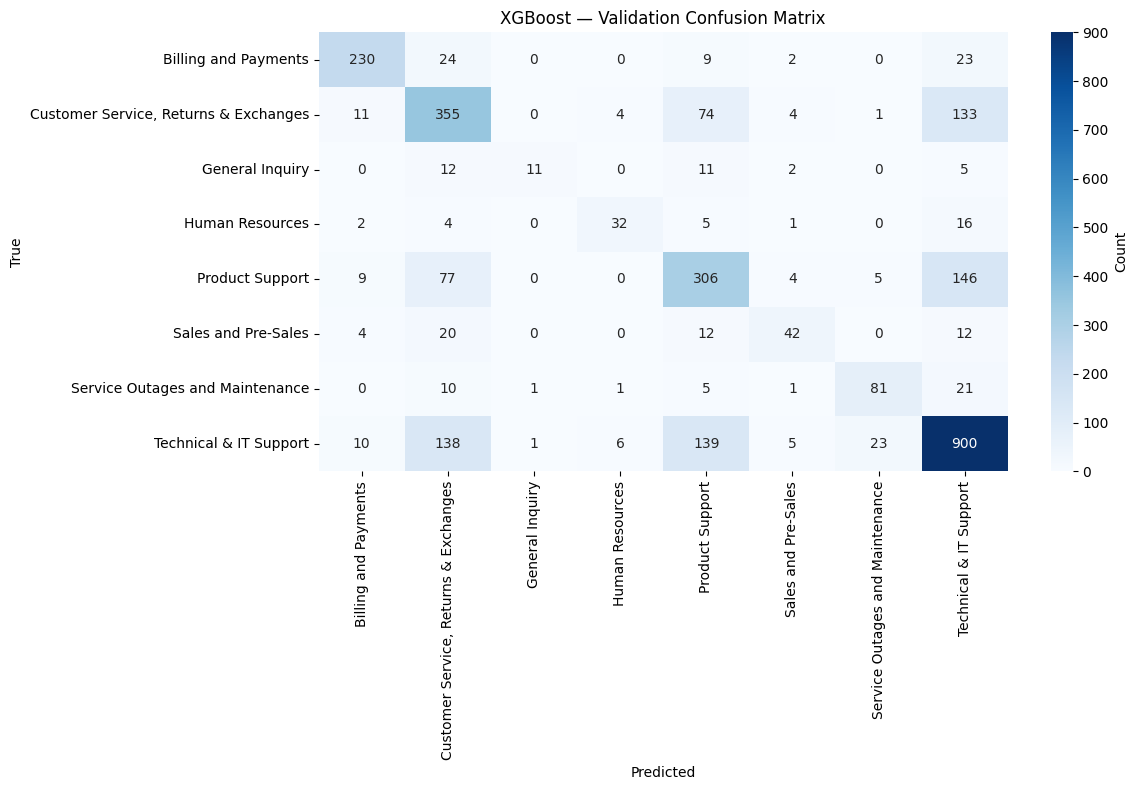

In [5]:
# declare xgb_X and xgb_y for XGBoost
xgb_raw_y = val_data["queue_grouped"].astype(str)
xgb_enc_y = label_encoder.transform(xgb_raw_y)

# use Sentence Transformer embeddings as features
xgb_X = val_embeddings

# make predictions
xgb_preds = xgb_model.predict(xgb_X)

# evaluate model
xgb_macro_f1 = f1_score(xgb_enc_y, xgb_preds, average="macro")
xgb_weighted_f1 = f1_score(xgb_enc_y, xgb_preds, average="weighted")

# save results 
results_rows.append({
    "model": "XGBoost",
    "representation": "Embeddings",
    "macro_f1": xgb_macro_f1,
    "weighted_f1": xgb_weighted_f1,
})

# print f1 scores and plot confusion matrix
print(f"XGBoost Macro F1: {xgb_macro_f1:.4f}")
print(f"XGBoost Weighted F1: {xgb_weighted_f1:.4f}")

plot_confusion_heatmap(
    y_true=xgb_enc_y,
    y_pred=xgb_preds,
    class_names=label_encoder.classes_,
    title="XGBoost — Validation Confusion Matrix",
)

#### Random Forest Classifier

Random Forest Macro F1: 0.6319
Random Forest Weighted F1: 0.6973


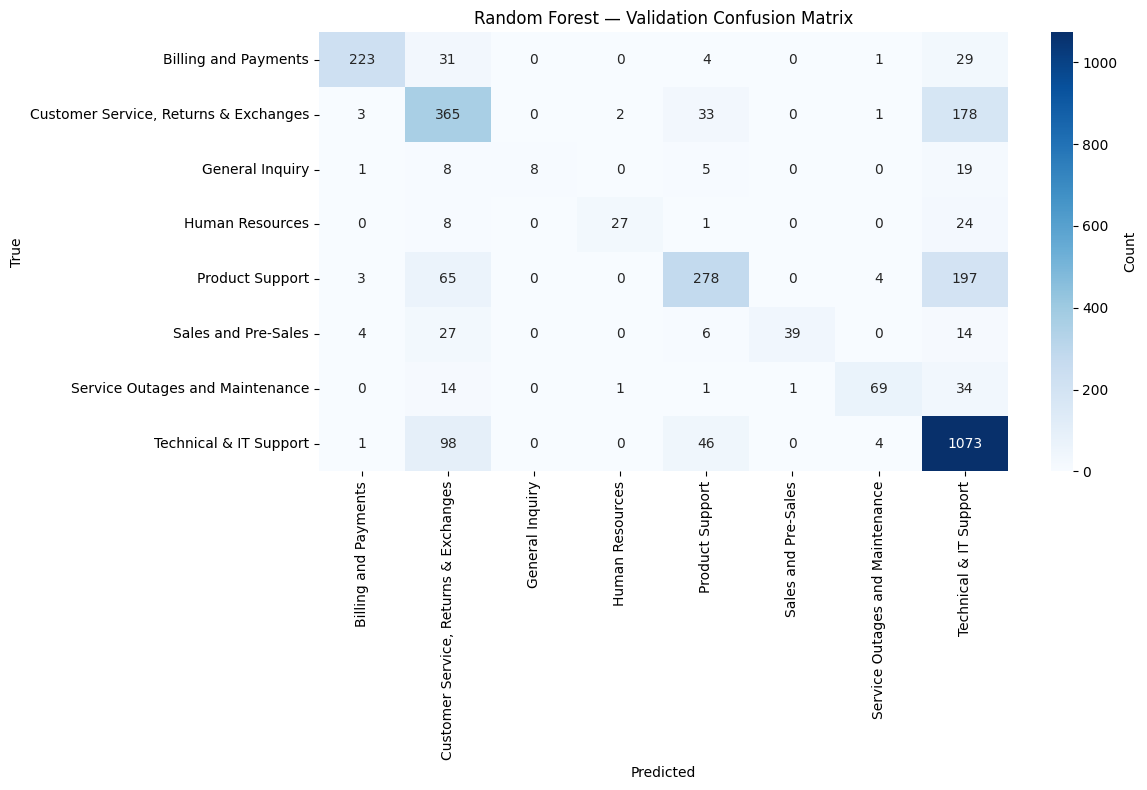

In [6]:
# declare rfc_X and rfc_y for Random Forest
rfc_raw_y = val_data["queue_grouped"].astype(str)
rfc_enc_y = label_encoder.transform(rfc_raw_y)

# use Sentence Transformer embeddings as features
rfc_X = val_embeddings

# make predictions
rfc_preds = rf_model.predict(rfc_X)

# evaluate model
rf_macro_f1    = f1_score(rfc_enc_y, rfc_preds, average="macro")
rf_weighted_f1 = f1_score(rfc_enc_y, rfc_preds, average="weighted")

# save results for visualization 
results_rows.append({
    "model": "Random Forest",
    "representation": "Embeddings",
    "macro_f1": rf_macro_f1,
    "weighted_f1": rf_weighted_f1,
})

# print f1 scores and plot confusion matrix
print(f"Random Forest Macro F1: {rf_macro_f1:.4f}")
print(f"Random Forest Weighted F1: {rf_weighted_f1:.4f}")

plot_confusion_heatmap(
    y_true=rfc_enc_y,
    y_pred=rfc_preds,
    class_names=label_encoder.classes_,
    title="Random Forest — Validation Confusion Matrix",
)

#### Support Vector Classification

SVC Macro F1: 0.7458
SVC Weighted F1: 0.7891


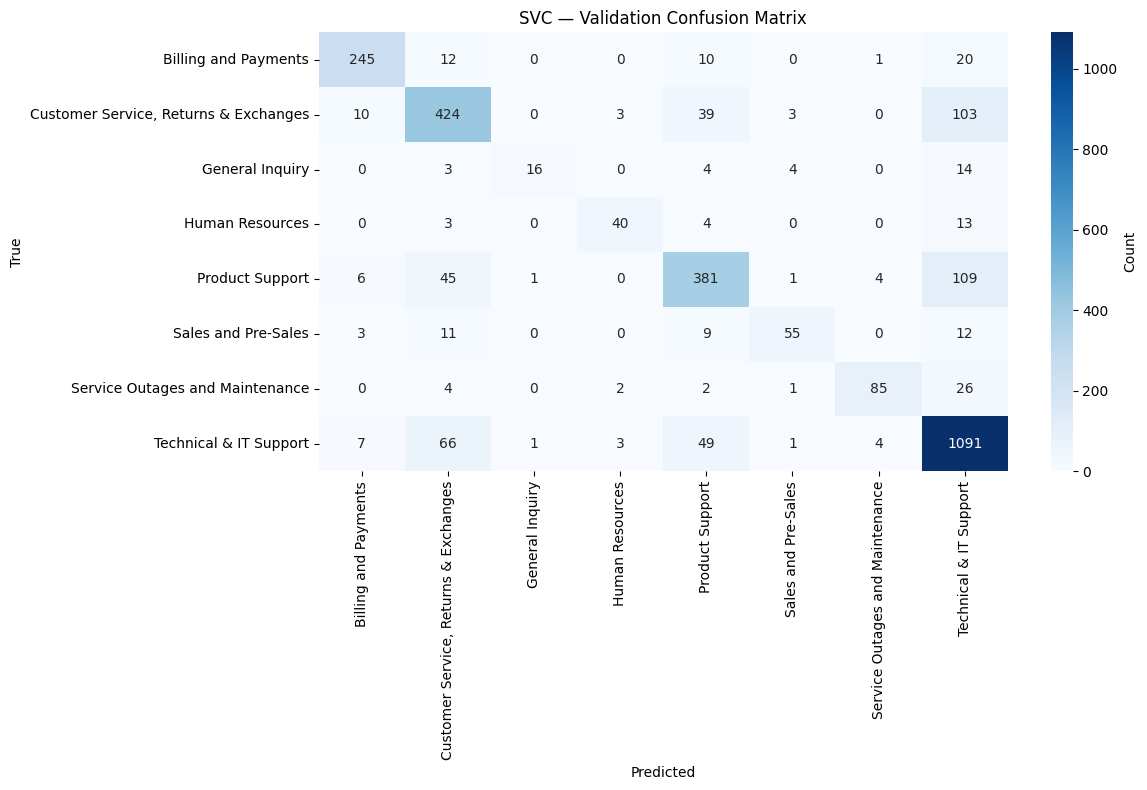

In [7]:
# declare svc_X and svc_y for Support Vector Classifier
svc_raw_y = val_data["queue_grouped"].astype(str)
svc_enc_y = label_encoder.transform(svc_raw_y)

# use Sentence Transformer embeddings as features, then scale
svc_X = val_embeddings
svc_X_scaled = scaler.transform(svc_X)

# make predictions
svc_preds = svm_model.predict(svc_X_scaled)

# evaluate model
svc_macro_f1    = f1_score(svc_enc_y, svc_preds, average="macro")
svc_weighted_f1 = f1_score(svc_enc_y, svc_preds, average="weighted")

# save results for visualization
results_rows.append({
    "model": "SVC",
    "representation": "Embeddings",
    "macro_f1": svc_macro_f1,
    "weighted_f1": svc_weighted_f1,
})

# print f1 scores and plot confusion matrix
print(f"SVC Macro F1: {svc_macro_f1:.4f}")
print(f"SVC Weighted F1: {svc_weighted_f1:.4f}")

plot_confusion_heatmap(
    y_true=svc_enc_y,
    y_pred=svc_preds,
    class_names=label_encoder.classes_,
    title="SVC — Validation Confusion Matrix",
)


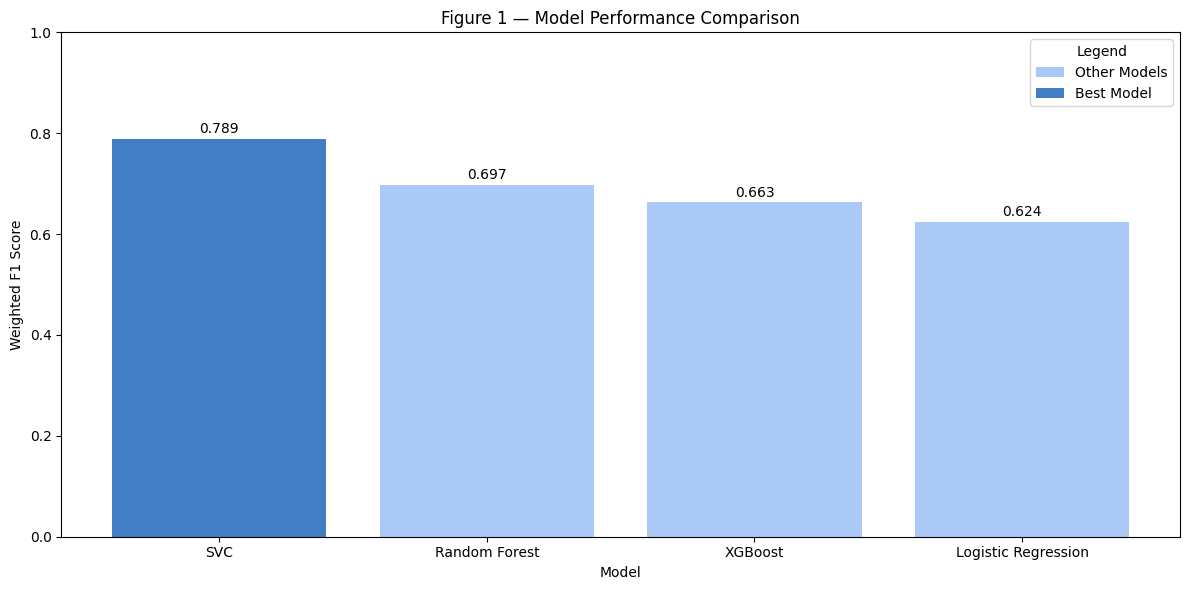

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sort by weighted_f1
results_df = pd.DataFrame(results_rows).sort_values("weighted_f1", ascending=False).reset_index(drop=True)

# Numeric x positions
x = np.arange(len(results_df))
scores = results_df["weighted_f1"].values
labels = results_df["model"].values

# find best model
best_idx = int(scores.argmax()) if hasattr(scores, "argmax") else int(np.argmax(scores))

# Colors
best_color = "#417ec3"
other_color = "#aac9f7"

plt.figure(figsize=(12, 6))

# Plot others
other_mask = np.ones(len(results_df), dtype=bool)
other_mask[best_idx] = False
plt.bar(x[other_mask], scores[other_mask], color=other_color, label="Other Models")

# Plot best
plt.bar(x[best_idx], scores[best_idx], color=best_color, label="Best Model")

# Annotations (now use numeric x positions)
for xi, val in zip(x, scores):
    plt.text(xi, val + 0.005, f"{val:.3f}", ha="center", va="bottom", fontsize=10)

# Axes/legend
plt.xticks(x, labels)
plt.legend(title="Legend")
plt.title("Figure 1 — Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Weighted F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
